In [1]:
import os
os.environ["R_HOME"] = "/home/michael/anaconda3/envs/torch/lib/R"
import numpy as np
import src as ddfa_node
import matplotlib.pyplot as plt
import importlib
import torch
importlib.reload(ddfa_node)
%load_ext autoreload
%autoreload 2

## Load and prepare data

In [2]:
def load_data_normalize(obs_dim, datafilepath):
    data = np.load(datafilepath)
    traj_tot = np.load(datafilepath).reshape(72, 1500, obs_dim)
    traj_tot = traj_tot[:,150:1350,:]
    data = data[:, 300:1200, :]
    data = data.reshape(72, 900, obs_dim)
    noise_std = 0.2

    orig_trajs = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            trajs = data[i,:,j]
            trajs_tot = traj_tot[i,:,j]
            orig_trajs[i,:,j] = (trajs - trajs_tot.mean()) / trajs_tot.std()
            
    #samp_trajs += npr.randn(*samp_trajs.shape) * noise_std #add noise

    return orig_trajs


In [3]:
data_path = "/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy"
data = load_data_normalize(6, '/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy')

In [4]:
# time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
time_delayed_data = ddfa_node.takens_embedding(data, 19, 9)

## Train and evaluate model

In [5]:
def split_data(data, train_size=0.5):
    n = data.shape[0]
    n_train = int(n * train_size)
    return data[:, :n_train, :], data[:, n_train:, :]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_train, data_val = ddfa_node.split_data(time_delayed_data, 0.5)
data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)
batch_size = 72

ts_num = 2.5
tot_num = data_train.shape[1]

samp_ts = np.linspace(0, ts_num, num=tot_num)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

val_num = ts_num / tot_num * data_val.shape[1]
val_ts = np.linspace(0, val_num, data_val.shape[1])
val_ts = torch.from_numpy(val_ts).float().to(device)

In [ ]:
latent_dim = 16
n_hidden = 128
dec_hidden = 64
obs_dim = data_train.shape[-1]
rnn_hidden = 64
n_itrs = 3000
noise_std = 0.2
lr = 5e-5


model = ddfa_node.train_network(data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr)

Iter: 0, running avg mse: 1.023084044456482, val_loss: 1.0334221124649048
Iter: 50, running avg mse: 1.0118788480758667, val_loss: 1.0228080749511719
Iter: 100, running avg mse: 1.0062271356582642, val_loss: 1.016595482826233
Iter: 150, running avg mse: 1.0021650791168213, val_loss: 1.0126491785049438
Iter: 200, running avg mse: 1.0004792213439941, val_loss: 1.0110565423965454
Iter: 250, running avg mse: 0.9991223216056824, val_loss: 1.0095443725585938
Iter: 300, running avg mse: 0.9980258941650391, val_loss: 1.0081450939178467
Iter: 350, running avg mse: 0.9974281787872314, val_loss: 1.0076947212219238
Iter: 400, running avg mse: 0.9968913793563843, val_loss: 1.0072630643844604
Iter: 450, running avg mse: 0.9964653253555298, val_loss: 1.006998062133789
Iter: 500, running avg mse: 0.9961845278739929, val_loss: 1.0067862272262573
Iter: 550, running avg mse: 0.9958499670028687, val_loss: 1.006330966949463
Iter: 600, running avg mse: 0.9950169324874878, val_loss: 1.0054906606674194
Iter: 

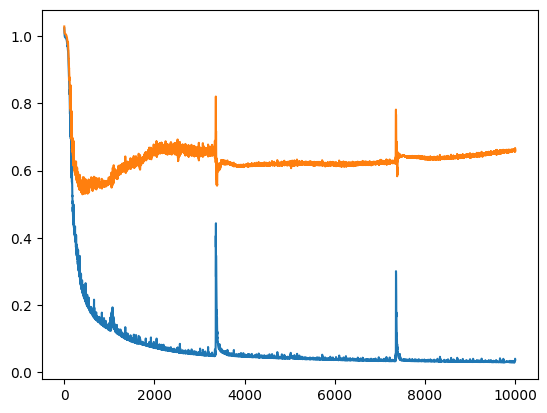

In [9]:
%matplotlib inline
plt.plot(model[3])
plt.plot(model[4])
plt.show()

In [ ]:
metrics = model.evaluate()

## Get self-driven data

In [ ]:
self_generated_data = ddfa_node.generate_data_from_model(model, steps=5000)

## Estimate Floquet multipliers

In [ ]:
λs = ddfa_node.get_FM(self_generated_data)

## Visualize Floquet multipliers

In [ ]:
ddfa_node.make_FM_plots(λs)